In [3]:
!pip install jiwer tensorflow IPython librosa
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import IPython.display as ipd

In [4]:
from google.colab import drive

drive.mount('/content/drive')

wavs_path = '/content/drive/My Drive/audio/audio/'
metadata_path = '/content/drive/My Drive/audio/clip1.csv'

metadata_df = pd.read_csv(metadata_path, sep=',', header=None, quoting=3)

metadata_df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,0,1
0,clip_1,asante kwa zawadi ya roho wako mtakatifu roho ...
1,clip_2,asante bwana kwasababu pamoja na maumivu tulio...
2,clip_3,hali zingine ambazo hatuzielewi wakati mwingin...
3,clip_4,za kufanya njia hata pasipo na njia tunakushuk...
4,clip_5,ine tena tunajikabidhi mikononi mwako siku nyi...
5,clip_6,gange ukatuponye na ukafanye jambo ulilokusubi...
6,clip_7,mshangilie bwana Yesu kwa makofi mengi makofi ...
7,clip_8,Amen Amen aya mkaribishe jilani yako mwambie k...
8,clip_9,Kristo alafu naomba jamani wale ambao tumekaa ...
9,clip_10,n’ghe shuleni ulikuwa back bencher kazini inaw...


In [5]:
audio1= wavs_path+'clip_10.wav'
ipd.Audio(audio1)

Output hidden; open in https://colab.research.google.com to view.

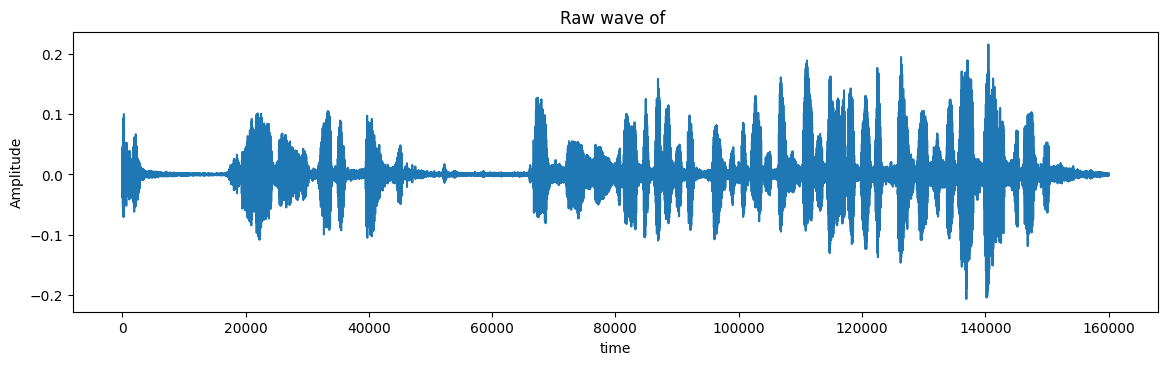

In [7]:
import librosa
samples, sample_rate = librosa.load(wavs_path+'clip_10.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(samples)

In [8]:
metadata_df.columns = ['file_name', 'transcription']
metadata_df = metadata_df[['file_name', 'transcription']]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,transcription
0,clip_117,vi naeleweka ehe okay Amen mh mkiwa siliasi sa...
1,clip_5,ine tena tunajikabidhi mikononi mwako siku nyi...
2,clip_211,zia puani pumzi ya uhai anaandika anasema akam...


In [9]:
split = int(len(metadata_df)* .90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f'Size of the training set: {len(df_train)}')
print(f'Size of the training set: {len(df_val)}')


Size of the training set: 198
Size of the training set: 22


In [10]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_cha = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


In [11]:
frame_length = 256
frame_step = 160
fft_length = 380

def encode_signal_sample(wav_file, label):
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    audio, sample_rate = tf.audio.decode_wav(file)
    if len(audio.shape) > 1:
        audio = tf.reduce_mean(audio, axis=-1)

    audio = tf.cast(audio, tf.float32)

    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)

    spectrogram = tf.math.pow(spectrogram, 0.5)

    means = tf.math.reduce_mean(spectrogram, axis=1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, axis=1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    return spectrogram, label


In [12]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((list(df_train["file_name"]), list(df_train["transcription"])))

train_dataset = (
    train_dataset.map(encode_signal_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
validation_dataset = tf.data.Dataset.from_tensor_slices((
    list(df_val['file_name']), list(df_val['transcription'])
))
validation_dataset = (
    validation_dataset.map(encode_signal_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


In [13]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 191), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

<Figure size 800x500 with 0 Axes>

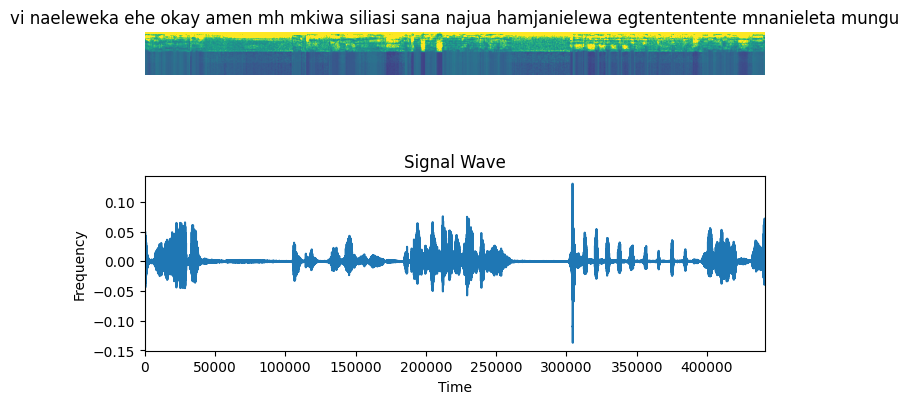

In [14]:
figer = plt.figure(figsize=(8,5))
for batch in train_dataset.take(1):
    fig = plt.figure(figsize=(8,5))
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    label = tf.strings.reduce_join(num_to_cha(label)).numpy().decode("utf-8")
    ax = plt.subplot(2,1,1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    wav_file = df_train['file_name'].iloc[0]
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    audio, _ = tf.audio.decode_wav(file)

    if len(audio.shape) > 1:
        audio = tf.reduce_mean(audio, axis=-1)  # Convert to mono if stereo

    audio = audio.numpy()
    ax = plt.subplot(2,1,2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_aspect("auto")
    ax.set_xlabel("Time")
    ax.set_ylabel("Frequency")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()



In [15]:
def CTCLoss(y_train, y_pred):
    batch_len = tf.cast(tf.shape(y_train)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_train)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = keras.backend.ctc_batch_cost(y_train, y_pred, input_length, label_length)
    return loss


In [16]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    input_spectrogram = layers.Input((None, input_dim), name="input")
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2,2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1,2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)

    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss=CTCLoss)
    return model

model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)



Model: "DeepSpeech_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                             │ (None, None, 191)                   │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ expand_dim (Reshape)                           │ (None, None, 191, 1)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1 (Conv2D)                                │ (None, None, 96, 32)                │              14,432 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_bn (BatchNormalization)                 │ (None, None, 96, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_1_relu (ReLU)                             │ (None, None, 96, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2 (Conv2D)                                │ (None, None, 48, 32)                │             236,544 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_bn (BatchNormalization)                 │ (None, None, 48, 32)                │                 128 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv_2_relu (ReLU)                             │ (None, None, 48, 32)                │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ reshape (Reshape)                              │ (None, None, 1536)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_1 (Bidirectional)                │ (None, None, 1024)                  │           6,297,600 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout (Dropout)                              │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_2 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_3 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_2 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ bidirectional_4 (Bidirectional)                │ (None, None, 1024)                  │           4,724,736 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_3 (Dropout)                            │ (None, None, 1024)                  │                   0 │
├───

 Total params: 26,530,176 (101.20 MB)

 Trainable params: 26,530,048 (101.20 MB)

 Non-trainable params: 128 (512.00 B)

In [17]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_cha(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

class CallbackEval(keras.callbacks.Callback):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset


    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_cha(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)



In [ ]:
epochs = 10
validation_callback = CallbackEval(validation_dataset)
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/2
